# Get metrics iLOVECLIM - Article version
Author: Maya Janvier

Date: 10/07/2023

In [1]:
# dependencies 

import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import subprocess
import os
import json
from joblib import Parallel, delayed
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from scipy.stats import entropy
import joblib
import math 
import warnings
warnings.filterwarnings("ignore")
joblib.__version__

'1.1.0'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
num_cores = multiprocessing.cpu_count()
num_cores

48

# Get parameters of the experiment
You can try 3 experiments:
- ATM_MEAN5
- ATM-EVO_MEAN20
- ATM-EVO_MEAN100
- ATM-EVO_MEAN100-20
- ATM-EVO_MV100

In [3]:
choose_exp ="ATM-EVO_MEAN20"

In [4]:
with open(f"parameters/simulations/{choose_exp}_params.json") as fp:
    parameters_dict = json.load(fp)

NB_YEAR_SIMU = parameters_dict["NB_YEAR_SIMU"]
NB_YEAR_TRUTH = parameters_dict["NB_YEAR_TRUTH"]
NAME_START = parameters_dict["NAME_START"]
NAME_EXP = parameters_dict["NAME_EXP"]

parameters_dict

{'NB_YEAR_SIMU': 20,
 'NB_YEAR_TRUTH': 20,
 'NAME_START': 'SHI_START',
 'NAME_EXP': 'ATM-EVO_MEAN_20L',
 'WAVE_K_MEANS': 1,
 'WAVE_CANDIDATE': 2}

In [5]:
with open("parameters/truth/truth_params.json") as fp:
    param_truth = json.load(fp)
    
N_PARAM = len(param_truth)
param_truth

{'ampwir': 1.0,
 'expir': 0.4,
 'relhmax': 0.83,
 'alphd': 0.72,
 'ai': 300,
 'cwdrag': 0.0021,
 'aitd': 300,
 'avkb': 1.5e-05,
 'cgren': 0.04}

# Definition of useful functions

In [6]:
# PCA     
def reduce_pca(vector):   
    scaler = StandardScaler().fit(vector)
    datascaled = scaler.transform(vector)
    ###########
    pca = PCA(n_components=0.99, svd_solver = 'full') #parameters contains 99% of the total variance
    pca.fit(datascaled)
    reduceddata = pca.transform(datascaled)
    return reduceddata, scaler, pca

def reduce_pca_usingwave1(vector, scaler, pca): 
    datascaled = scaler.transform(vector)
    return pca.transform(datascaled)

In [7]:
# vizualisation A COMPLETER 
def plot_simulation_points(inputs):
    plt.figure(figsize=(15,15))

    plt.subplot(2,5,2)
    plt.plot(inputs[:,1], inputs[:,2], ".", label="Simulation Points")
    plt.plot(param_truth['expir'], param_truth['relhmax'],"d", label="true")
    plt.xlabel("expir")
    plt.ylabel("relhmax")
    plt.legend()


    plt.subplot(2,5,1)
    plt.plot(inputs[:,0], inputs[:,1],".", label="Simulation Points")
    plt.plot(param_truth['ampwir'], param_truth['expir'],"d", label="true")
    plt.xlabel("ampwir")
    plt.ylabel("expir")
    plt.legend()

    plt.subplot(2,5,3)
    plt.plot(inputs[:,2], inputs[:,3],".", label="Simulation Points")
    plt.plot(param_truth['relhmax'], param_truth['alphd'],"d", label="true")
    plt.xlabel("relhmax")
    plt.ylabel("alphd")
    plt.legend()

    plt.subplot(2,5,4)
    plt.plot(inputs[:,3], inputs[:,0],".", label="Simulation Points")
    plt.plot(param_truth['alphd'], param_truth['ampwir'], "d", label="true")
    plt.xlabel("alphd")
    plt.ylabel("ampwir")
    plt.legend()

    plt.subplot(2,5,5)
    plt.plot(inputs[:,2], inputs[:,0],".", label="Simulation Points")
    plt.plot(param_truth['relhmax'], param_truth['ampwir'],"d", label="true")
    plt.xlabel("relhmax")
    plt.ylabel("ampwir")
    plt.legend()

    plt.subplot(2,5,6)
    plt.plot(inputs[:,1], inputs[:,3],".", label="Simulation Points")
    plt.plot(param_truth['expir'], param_truth['alphd'], "d", label="true")
    plt.xlabel("expir")
    plt.ylabel("alphd")
    plt.legend()
    
    plt.subplot(2,5,7)
    plt.plot(inputs[:,4], inputs[:,0],".", label="Simulation Points")
    plt.plot(param_truth['ai'], param_truth['ampwir'], "d", label="true")
    plt.xlabel("ai")
    plt.ylabel("ampwir")
    plt.legend()
    
    plt.subplot(2,5,8)
    plt.plot(inputs[:,4], inputs[:,1],".", label="Simulation Points")
    plt.plot(param_truth['ai'], param_truth['expir'], "d", label="true")
    plt.xlabel("ai")
    plt.ylabel("expir")
    plt.legend()
    
    plt.subplot(2,5,9)
    plt.plot(inputs[:,4], inputs[:,2],".", label="Simulation Points")
    plt.plot(param_truth['ai'], param_truth['relhmax'], "d", label="true")
    plt.xlabel("ai")
    plt.ylabel("relhmax")
    plt.legend()
    
    plt.subplot(2,5,10)
    plt.plot(inputs[:,4], inputs[:,3],".", label="Simulation Points")
    plt.plot(param_truth['ai'], param_truth['alphd'], "d", label="true")
    plt.xlabel("ai")
    plt.ylabel("alphd")
    plt.legend()

def plot_pc_1_2(targets_reduced, obs_reduced):
    sns.set_context("talk")

    sns.scatterplot(x=targets_reduced[:,0],y=targets_reduced[:,1],
                    hue=targets_reduced[:,0], palette='coolwarm', legend=False)
    plt.plot(obs_reduced[:,0],obs_reduced[:,1], 'r*', label='Ground Truth')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()

In [8]:
# save data 
def build_save_dataframe_metrics_to_csv(targets_reduced, nb_wave):
    df_metrics = pd.DataFrame()
    for i in range(targets_reduced.shape[1]):
        df_metrics['pca_'+str(i)] = targets_reduced[:,i]
    df_metrics.to_csv(f'../DATA/{NAME_EXP}/df_metrics_newPCA_wave{nb_wave}.csv', index=False)
    return df_metrics

def build_save_dataframe_obs_to_csv(targets_reduced, obs_reduced, nb_wave):
    df_obs_nonoise = pd.DataFrame()
    for i in range(targets_reduced.shape[1]):
        df_obs_nonoise['pca_'+str(i)] = obs_reduced[:,i]
    df_obs_nonoise.to_csv(f'../DATA/{NAME_EXP}/df_obs_nonoise_newPCA_wave{nb_wave}.csv', index=False)
    return df_obs_nonoise

## Metrics
Simple for now: only mean 

In [9]:
def metrics_atm_evo_n_last_years(ds_atm, ds_evolu, metrics_list, n_year=NB_YEAR_SIMU):
    variables = []
    # for ds_atm
    q = ds_atm.q.isel(time=slice(-(n_year+1),-1))
    ts = ds_atm.ts.isel(time=slice(-(n_year+1),-1))
    bm = ds_atm.bm.isel(time=slice(-(n_year+1),-1))
    shf = ds_atm.shf.isel(time=slice(-(n_year+1),-1))
    lhf = ds_atm.lhf.isel(time=slice(-(n_year+1),-1))
    r = ds_atm.r.isel(time=slice(-(n_year+1),-1))
    alb = ds_atm.alb.isel(time=slice(-(n_year+1),-1))
    ssr = ds_atm.ssr.isel(time=slice(-(n_year+1),-1))
    tsr = ds_atm.tsr.isel(time=slice(-(n_year+1),-1))
    Str = ds_atm.str.isel(time=slice(-(n_year+1),-1))
    ttr = ds_atm.ttr.isel(time=slice(-(n_year+1),-1))
    evap = ds_atm.evap.isel(time=slice(-(n_year+1),-1))
    pp = ds_atm.pp.isel(time=slice(-(n_year+1),-1))
    sp = ds_atm.sp.isel(time=slice(-(n_year+1),-1))
    snow = ds_atm.snow.isel(time=slice(-(n_year+1),-1))
    
    var_atm = []
    
    # for ds_evolu
    ADPro = ds_evolu.ADPro.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    AABex = ds_evolu.AABex.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    Fc30A = ds_evolu.Fc30A.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    T1mo = ds_evolu.T1mo.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    S1mo = ds_evolu.S1mo.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    VOLN = ds_evolu.VOLN.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    VOLS = ds_evolu.VOLS.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    A15N = ds_evolu.A15N.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    A15S = ds_evolu.A15S.isel(lat=0, lev=0, lon=0).isel(time=slice(-(n_year+1),-1))
    
    variables = [q, ts, bm, shf, lhf, r, alb, ssr, tsr, Str, ttr, evap, pp, sp, snow,
                 ADPro, AABex, Fc30A, T1mo, S1mo, VOLN, VOLS, A15N, A15S]
    
    metrics_out = []

    for metric in metrics_list:
        metrics_out += metric(variables)                
    
    return np.array(metrics_out)


In [10]:
def metrics_atm_n_last_years(ds_atm, ds_evolu, metrics_list, n_year=NB_YEAR_SIMU):
    variables = []
    # for ds_atm
    q = ds_atm.q.isel(time=slice(-(n_year+1),-1))
    ts = ds_atm.ts.isel(time=slice(-(n_year+1),-1))
    bm = ds_atm.bm.isel(time=slice(-(n_year+1),-1))
    shf = ds_atm.shf.isel(time=slice(-(n_year+1),-1))
    lhf = ds_atm.lhf.isel(time=slice(-(n_year+1),-1))
    r = ds_atm.r.isel(time=slice(-(n_year+1),-1))
    alb = ds_atm.alb.isel(time=slice(-(n_year+1),-1))
    ssr = ds_atm.ssr.isel(time=slice(-(n_year+1),-1))
    tsr = ds_atm.tsr.isel(time=slice(-(n_year+1),-1))
    Str = ds_atm.str.isel(time=slice(-(n_year+1),-1))
    ttr = ds_atm.ttr.isel(time=slice(-(n_year+1),-1))
    evap = ds_atm.evap.isel(time=slice(-(n_year+1),-1))
    pp = ds_atm.pp.isel(time=slice(-(n_year+1),-1))
    sp = ds_atm.sp.isel(time=slice(-(n_year+1),-1))
    snow = ds_atm.snow.isel(time=slice(-(n_year+1),-1))
    
    variables = [q, ts, bm, shf, lhf, r, alb, ssr, tsr, Str, ttr, evap, pp, sp, snow]
    metrics_out = []
    
    for metric in metrics_list:
        metrics_out += metric(variables)
        
    return np.array(metrics_out)
    

In [11]:
def mean_metric(ds_list):
    return [ds.mean().item() for ds in ds_list]

def variance_metric(ds_list):
    return [ds.var().item() for ds in ds_list]

def drift_metric(ds_list):
    return [(ds.isel(time=-1)- ds.isel(time=0)).mean().item() for ds in ds_list]

def ten_drift_metric(ds_list):
    return [(ds.isel(time=-1)- ds.isel(time=-11)).mean().item() for ds in ds_list]

def final_drift_metric(ds_list):
    return [(ds.isel(time=-1)- ds.isel(time=-2)).mean().item() for ds in ds_list]

def final_variance_metric(ds_list):
    return [ds.isel(time=slice(-2,-1)).var().item() for ds in ds_list]

def ten_variance_metric(ds_list):
    return [ds.isel(time=slice(-11,-1)).var().item() for ds in ds_list]


# Initialisation : ground truth
Run iLOVECLIM once with ground truth values for parameters. 

In [12]:
EXP = NAME_START
if 'EVO' in NAME_EXP:
    metrics = metrics_atm_evo_n_last_years # atmospheric and oceanic metrics
else:
    metrics = metrics_atm_n_last_years # atmospheric only 
if "MV" in NAME_EXP:
    METRICS_LIST = [mean_metric, variance_metric]
else:
    METRICS_LIST = [mean_metric] # type of metric
    
METRICS_LIST

[<function __main__.mean_metric(ds_list)>]

In [13]:
ground_truth_path = '/homedata/mjanvier/iloveclim/data/SHI_TRUTH_ecbilt_clio/output008000/'
evolu_truth = xr.open_dataset(ground_truth_path+"ocean/myevolu.nc").isel(time=slice(0,NB_YEAR_TRUTH*12))
atmos_truth = xr.open_dataset(ground_truth_path+"atmos/atmym008000.nc", decode_times=False).isel(time=slice(0,NB_YEAR_TRUTH))

In [14]:
display(atmos_truth)
display(evolu_truth)

<xarray.Dataset>
Dimensions:      (lon: 64, bnds: 2, lat: 32, P_T3: 3, P_T4: 4, P_U3: 3, time: 20)
Coordinates:
  * lon          (lon) float32 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat          (lat) float32 -85.76 -80.27 -74.74 -69.21 ... 74.74 80.27 85.76
  * P_T3         (P_T3) float32 1e+04 3.5e+04 6.5e+04
  * P_T4         (P_T4) float32 1e+04 3.5e+04 6.5e+04 1e+05
  * P_U3         (P_U3) float32 2e+04 5e+04 8e+04
  * time         (time) float32 8.001e+03 8.002e+03 ... 8.019e+03 8.02e+03
Dimensions without coordinates: bnds
Data variables: (12/42)
    lon_bounds   (lon, bnds) float64 ...
    lat_bounds   (lat, bnds) float64 ...
    time_bounds  (time, bnds) float64 ...
    q            (time, lat, lon) float64 ...
    ts           (time, lat, lon) float64 ...
    tstrat       (time, lat, lon) float64 ...
    ...           ...
    u            (time, P_U3, lat, lon) float64 ...
    v            (time, P_U3, lat, lon) float64 ...
    omega        (time, P_T3, lat, lon) float64 ...
    psi          (time, P_U3, lat, lon) float64 ...
    chi          (time, P_U3, lat, lon) float64 ...
    geopg        (time, P_U3, lat, lon) float64 ...
Attributes: (12/26)
    title:                  iLOVECLIM1.1.1 model output prepared for unknown-...
    institution:            LSCE - Laboratoire des Sciences du Climat et de l...
    source:                 incremented from iLOVECLIM1.1 (2018) - atmosphere...
    contact:                didier.roche@lsce.ipsl.fr, didier.roche@vu.nl
    project_id:             ACCLIMATE ERC / FP7/2007-2013 Grant agreement n° ...
    table_id:               Table Amon ??? ref to be updated
    ...                     ...
    physics_version:        1
    tracking_id:            ba494858-2c5d-4283-75a0-14106bcf484b
    product:                output
    frequency:              yr
    creation_date:          2023-06-07T15:42:53Z
    modeling_realm:         atmos

<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1, lev: 1, time: 240)
Coordinates:
  * lon      (lon) float32 1.0
  * lat      (lat) float32 1.0
  * lev      (lev) float32 1.0
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 ... 237.0 238.0 239.0 240.0
Data variables: (12/97)
    NoIt     (time, lev, lat, lon) float32 ...
    Tyr      (time, lev, lat, lon) float32 ...
    EgAjC    (time, lev, lat, lon) float32 ...
    V_AjC    (time, lev, lat, lon) float32 ...
    D_Eta    (time, lev, lat, lon) float32 ...
    M_Eta    (time, lev, lat, lon) float32 ...
    ...       ...
    SPNG     (time, lev, lat, lon) float32 ...
    BERG     (time, lev, lat, lon) float32 ...
    ThEx     (time, lev, lat, lon) float32 ...
    ISMM     (time, lev, lat, lon) float32 ...
    IcbN     (time, lev, lat, lon) float32 ...
    IcbS     (time, lev, lat, lon) float32 ...
Attributes:
    history:      LOVECLIM Ocean output (evolu) converted by procevolu
    title:        Evolution of the Ocean (EVOLU) CLIO
    institution:  VU AMS, LUDUS, LOVECLIM
    comment:      Temporal Resolution in months

In [15]:
TrueTraj = metrics(atmos_truth, evolu_truth, METRICS_LIST) # ground truth
TrueTraj.shape

(24,)

# Wave 1

In [16]:
inputs_1 = pd.read_csv(f"../DATA/{NAME_EXP}/df_inputs_newPCA_wave1.csv") 
inputs_1.shape

(90, 9)

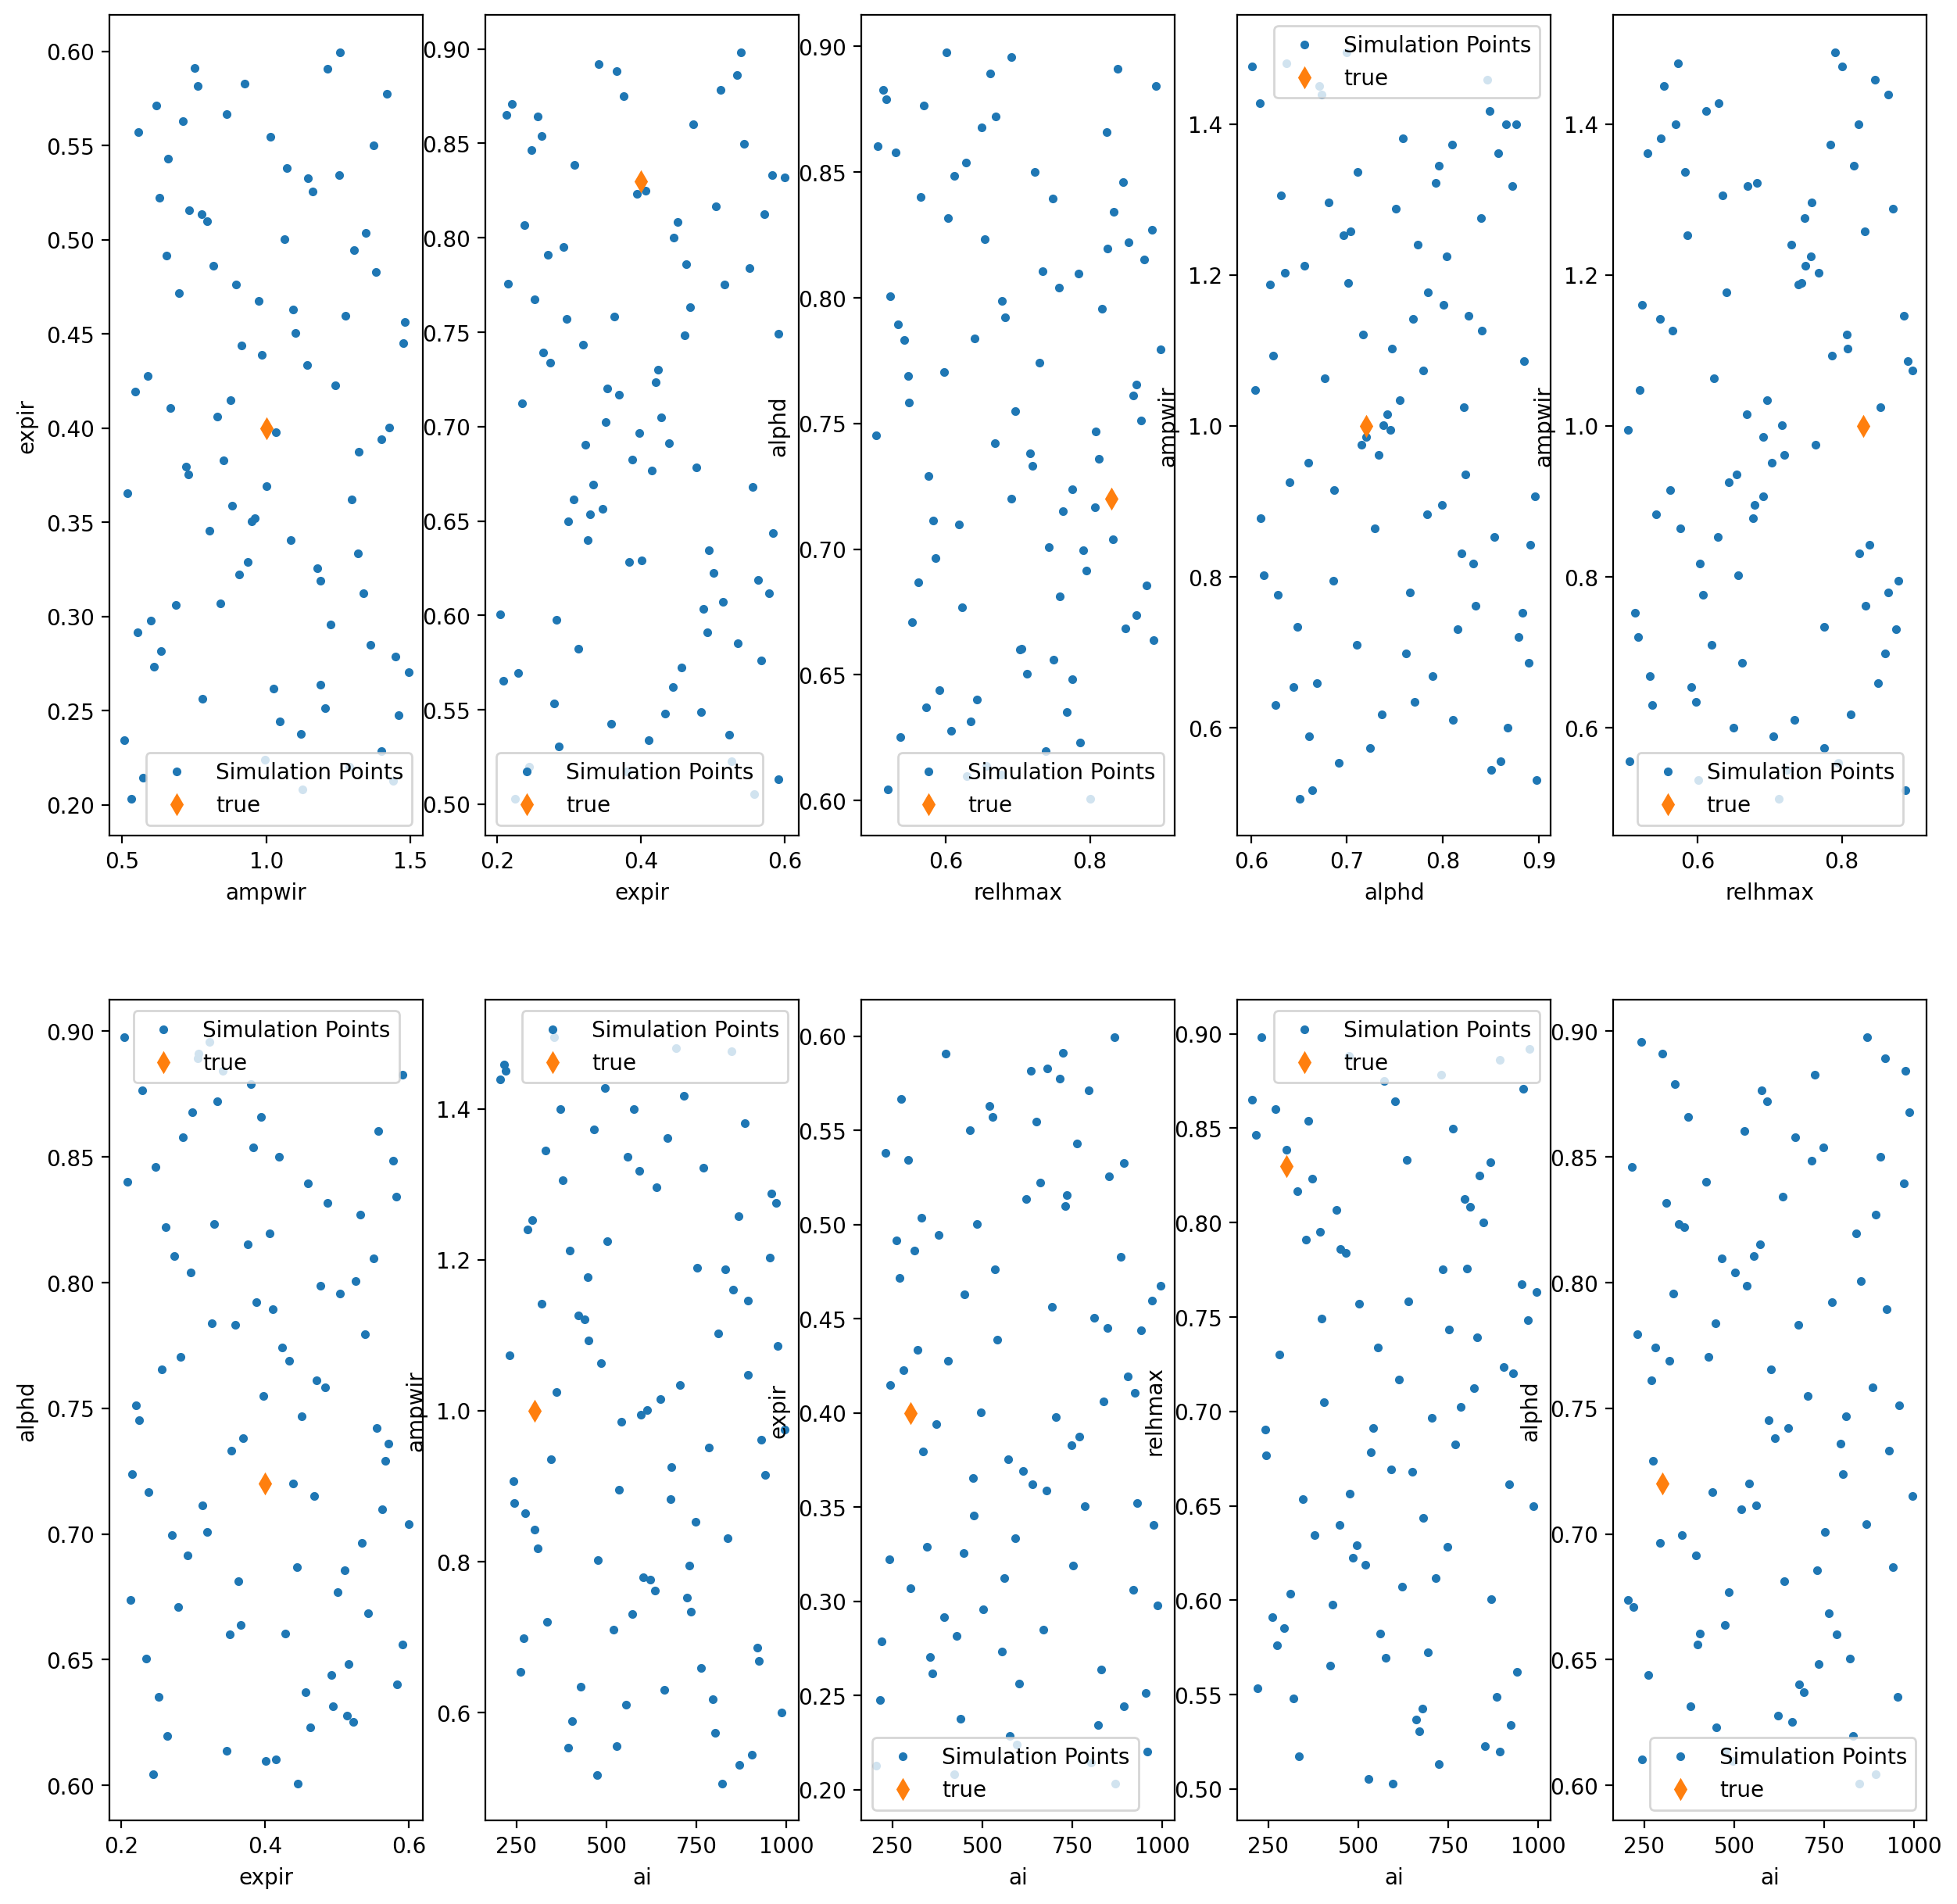

In [17]:
plot_simulation_points(inputs_1.values)

### Launch simulations via bash script

Now we have to run the model with these 90 combinations of parameters. 

In [18]:
# create data file for iLOVECLIM
if not os.path.exists(f'../OUT_DATA/{EXP}HM_values.dat'): 
    print("Writing file")
    inputs_1.to_csv(f'../OUT_DATA/{EXP}HM_values.dat', header=None, sep='\t') # .dat file for bash script 

**_Launch iLOVECLIM simulations. Wait for the simulations to finish_**

### Get all the atmos and evolu files for metrics
Wave 1: 1 to 90: Wave 2: 91 to 180 etc...

In [19]:
 def get_metrics_wave(nb_wave, n_param=N_PARAM, sample_size=10):
    root = '/homedata/mjanvier/iloveclim/wkdir'
    results = []
    indices_simu = []
    fails = []
    for n_simu in range((nb_wave-1)*n_param*sample_size+1, nb_wave*n_param*sample_size+1):
        path_evolu = root+f'/{EXP}{n_simu}_ecbilt_clio/run/outputdata/ocean/myevolu.nc' 
        path_atmos = root+f'/{EXP}{n_simu}_ecbilt_clio/run/outputdata/atmos/atmym008000.nc'

        if os.path.exists(path_evolu):
            ds_evolu = xr.open_dataset(path_evolu)
            ds_atmos = xr.open_dataset(path_atmos, decode_times=False)
            results.append(metrics(ds_atmos, ds_evolu, METRICS_LIST))
            indices_simu.append(n_simu)
        else:
            fails.append(n_simu)

    if len(fails) != 0:
        fails = np.array(fails) - N_PARAM*10*(nb_wave-1)
        (pd.DataFrame(fails)).to_csv(f'../DATA/{NAME_EXP}/fails_wave{nb_wave}.csv', index=False)
    return np.array(results), np.array(indices_simu)- 1 - N_PARAM*10*(nb_wave-1)

In [20]:
def wave_1(inputs, true_traj):    
    targets, valid_simus = get_metrics_wave(1)

    # ensure the simulations converged
    inputs = inputs.iloc[valid_simus]
    inputs = inputs.values[np.all(np.isfinite(targets), axis=1)] 
    
    targets = targets[np.all(np.isfinite(targets), axis=1)] 
    
    # PCA wave 1
    targetsreduced, SC, PC = reduce_pca(targets)
    Obsreduced = reduce_pca_usingwave1(true_traj[None,:], SC, PC)
    print('PCA reduced target shape', targetsreduced.shape)
    print('PCA reduced obs shape', Obsreduced.shape)
    
    plot_pc_1_2(targetsreduced, Obsreduced)  
    plt.show()
    
    # save dataframe
    df_metrics = build_save_dataframe_metrics_to_csv(targetsreduced, 1)
    df_obs = build_save_dataframe_obs_to_csv(targetsreduced, Obsreduced, 1)
    
    print('Metrics')
    display(df_metrics)
    
    return Obsreduced, SC, PC

PCA reduced target shape (90, 11)
PCA reduced obs shape (1, 11)


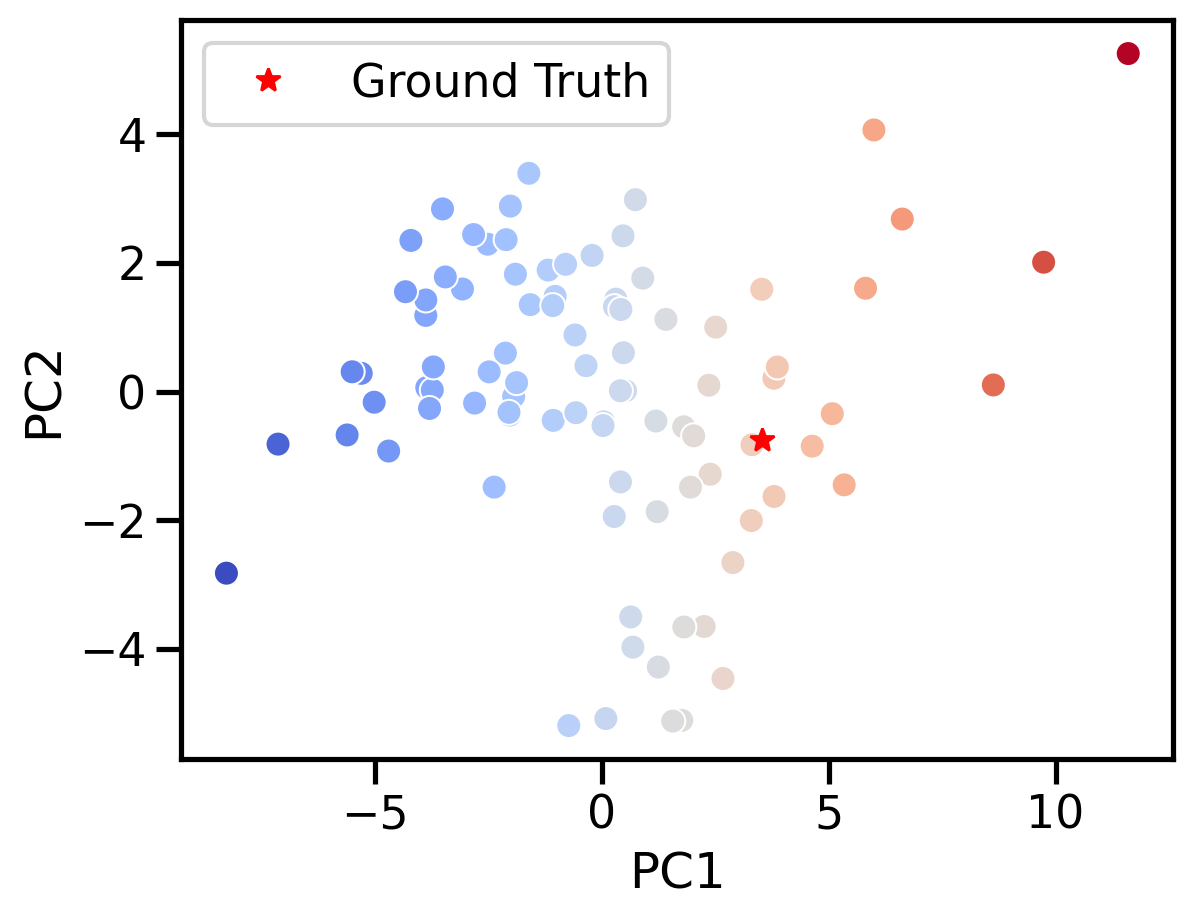

Metrics


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,0.309802,1.436455,0.114471,-1.041503,-0.225709,-0.348561,-0.228202,0.076329,-0.638474,0.059203,0.201832
1,1.191419,-0.459297,0.649582,1.142232,-0.349018,-0.438431,-0.006767,-0.382090,-0.213619,-0.088830,0.169896
2,0.277459,1.320667,-0.407968,-0.419074,-0.079283,-0.874039,-0.257473,0.290288,-0.489979,-0.064569,0.234022
3,0.041371,-0.472869,0.261843,1.348386,-0.343170,-0.276355,-0.190775,0.591879,0.060930,0.081881,0.042302
4,0.740923,2.984478,1.342671,-0.636593,0.293595,-0.345430,-0.103423,-0.173437,-0.662786,0.101805,0.291001
...,...,...,...,...,...,...,...,...,...,...,...
85,-4.326298,1.552359,-2.794925,-1.469992,-0.245823,-0.577382,-0.183829,-0.249733,0.422221,0.662413,0.077179
86,2.888471,-2.660449,-0.701443,-2.891491,0.706830,1.578496,-0.780360,-0.192167,0.496560,-0.418363,-0.259300
87,-2.015417,2.884219,1.719081,0.562736,-1.368165,-0.133002,-0.969236,0.070522,0.300291,-0.414427,-0.257458
88,1.563433,-5.125996,0.801537,-1.072642,-0.956013,1.434153,-0.890657,-0.656114,0.565652,0.395070,-0.389249


In [21]:
ObsReduced, SC, PC = wave_1(inputs_1 , TrueTraj)

**_Go back to the R notebook HM-TuningILC_**

## Next waves 

In [ ]:
EXP = NAME_EXP
inputs_1.to_csv(f'../OUT_DATA/{EXP}HM_values.dat', header=None, sep='\t')

In [ ]:
def load_inputs_wave(nb_wave):
    inputs = pd.read_csv(f"../DATA/{EXP}/exp_TuningL94_newPCA_wave{nb_wave}.csv") #.values
    return inputs

def update_HM_values(old_df, new_df):
    df = pd.concat([old_df, new_df])
    df.to_csv(f'../OUT_DATA/{EXP}HM_values.dat', header=None, sep='\t') 
    return df

In [ ]:
def wave(nb_wave, sc, pc, obs_reduced):
    print(f'WAVE {nb_wave}')
    inputs_wave = load_inputs_wave(nb_wave) #reload because other is for .dat file 
    targets, valid_simus = get_metrics_wave(nb_wave)
    
    # ensure the simulations converged
    inputs = inputs_wave.iloc[valid_simus]
    inputs = inputs[np.all(np.isfinite(targets), axis=1)]
    print(len(inputs))
    
    targets = targets[np.all(np.isfinite(targets), axis=1)]
    
    # PCA 
    targetsreduced = reduce_pca_usingwave1(targets, sc, pc)
    
    print(f'PCA WAVE {nb_wave}')
    plot_pc_1_2(targetsreduced, obs_reduced)
    plt.show()
    
    # save dataframe
    df_metrics = build_save_dataframe_metrics_to_csv(targetsreduced, nb_wave)

# Wave 2

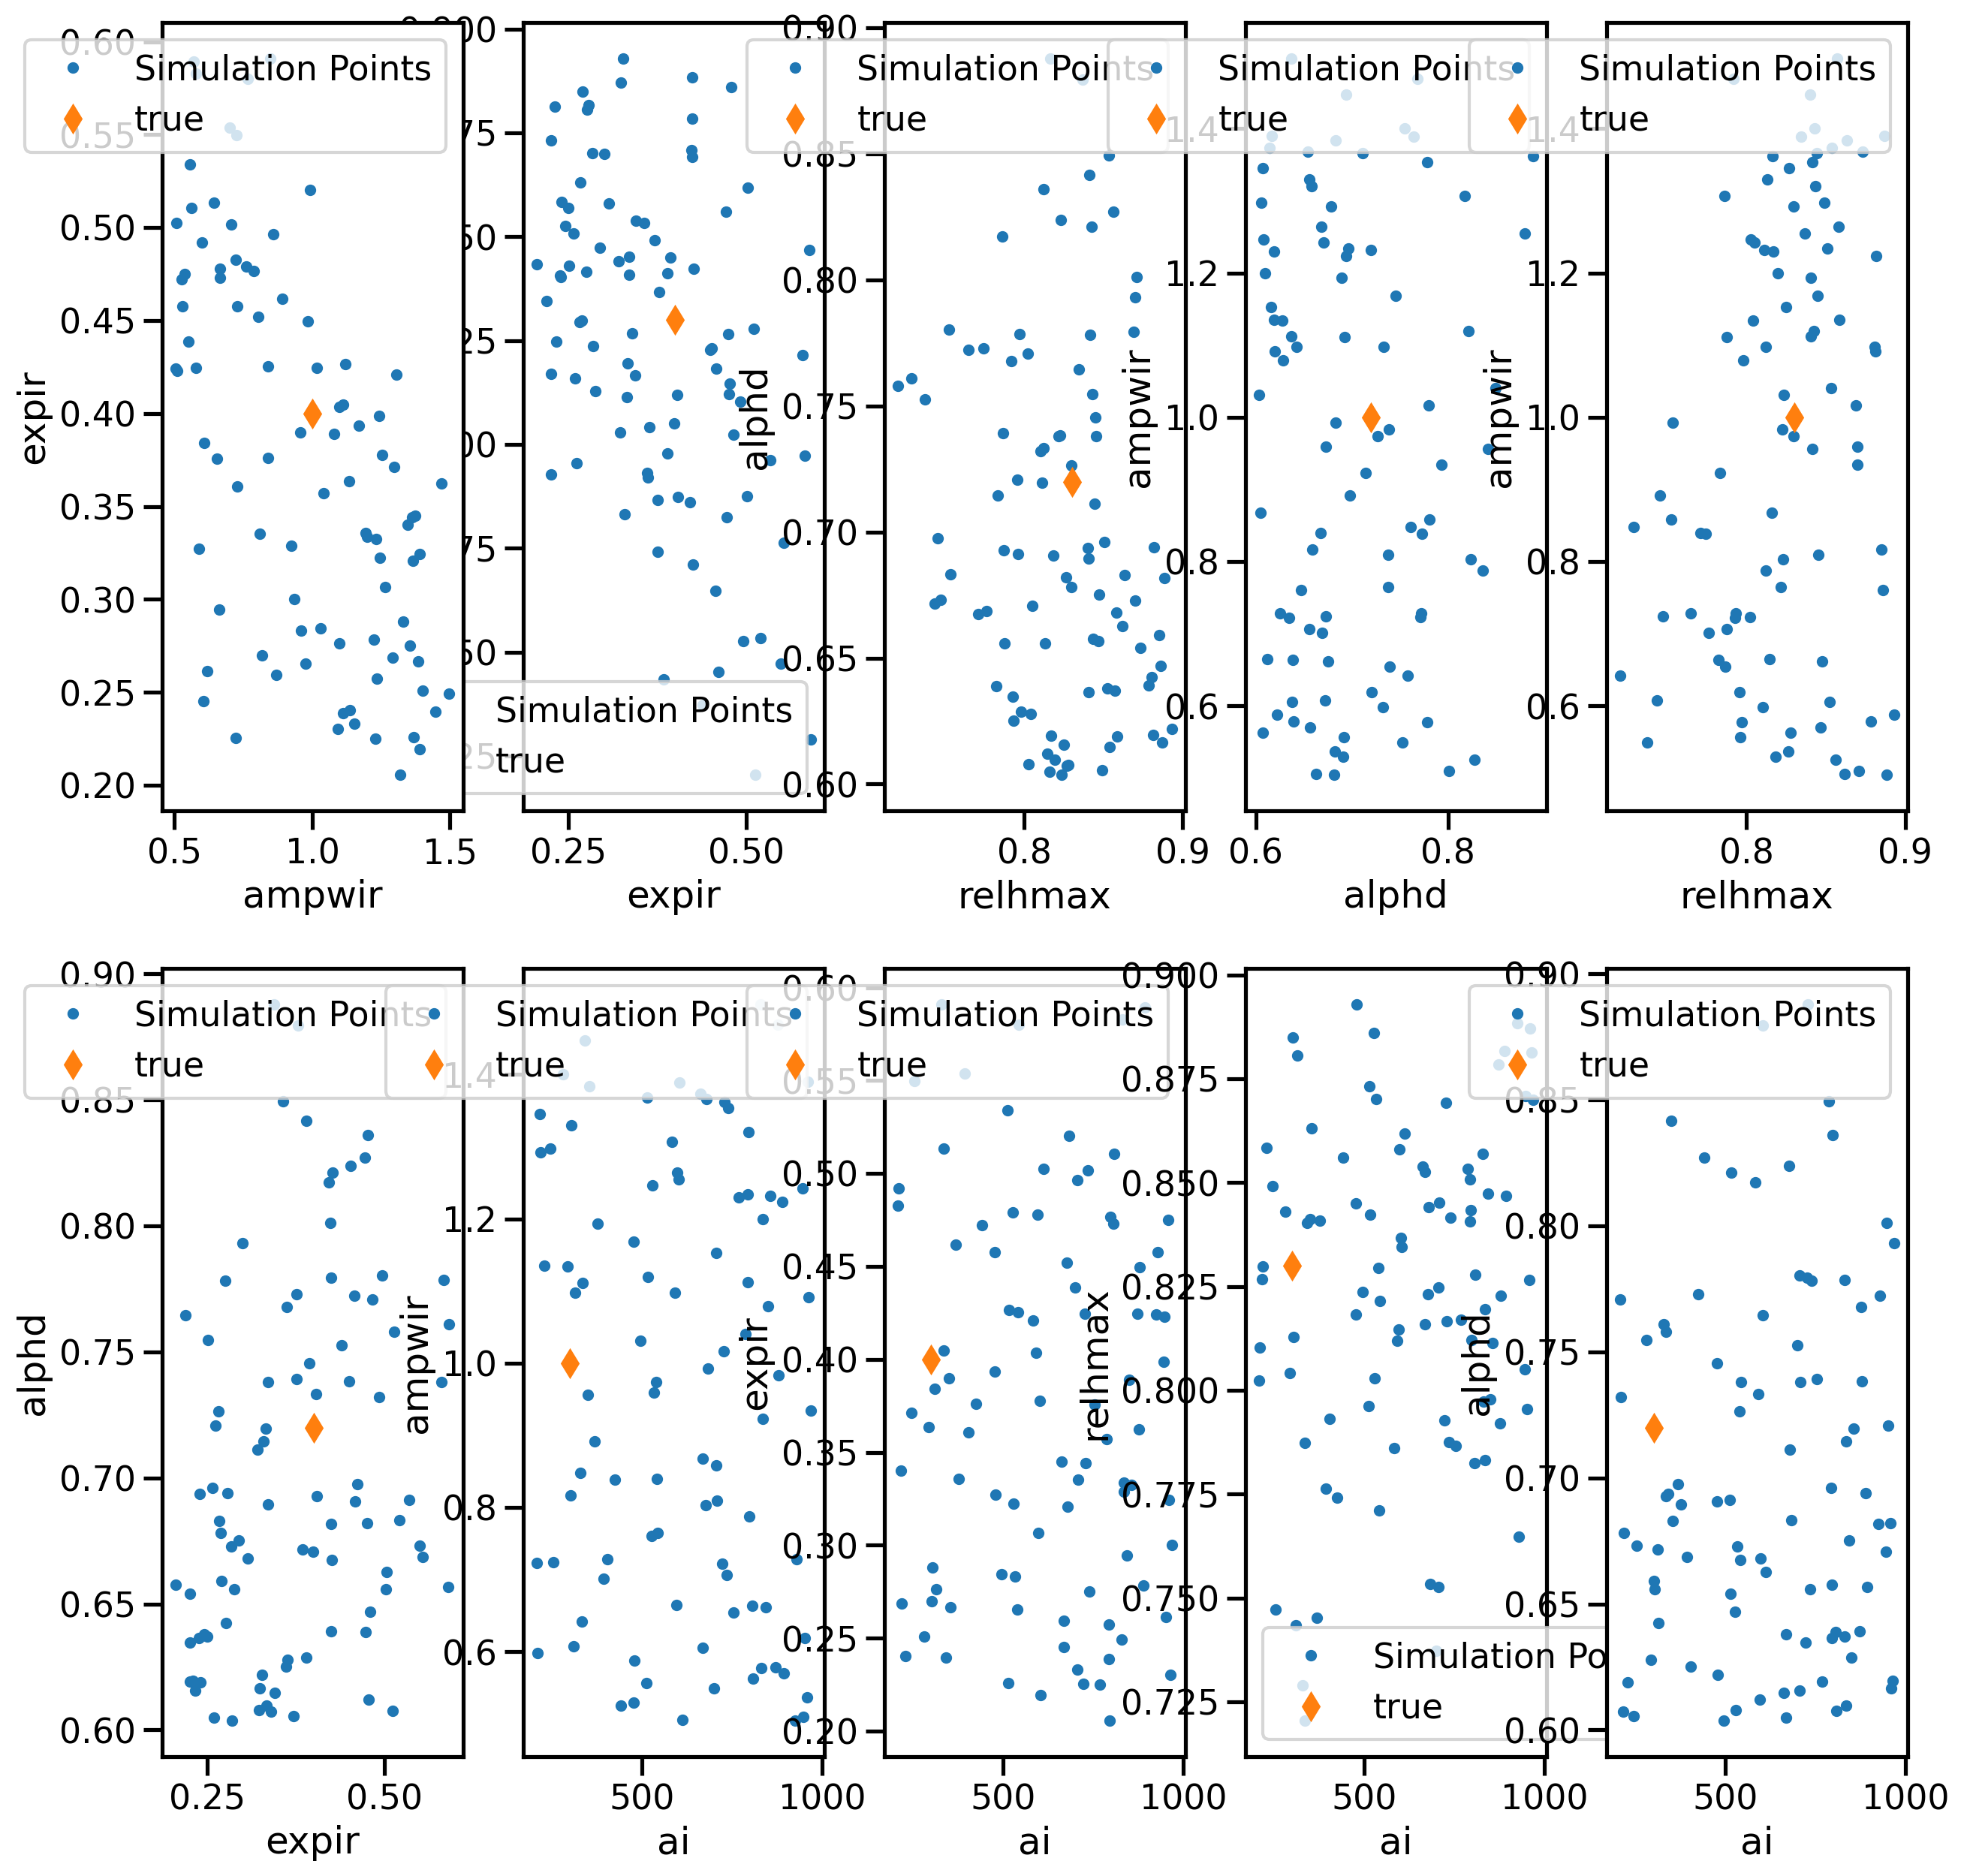

In [25]:
#### load new inputs 
inputs_old = inputs_1 
inputs_new = load_inputs_wave(2)
plot_simulation_points(inputs_new.values)

# add values to HM_values.dat
inputs_old = update_HM_values(inputs_old, inputs_new)

# launch simulations 

**_Launch iLOVECLIM simulations. Wait for the simulations to finish_** 

WAVE 2
90
PCA WAVE 2


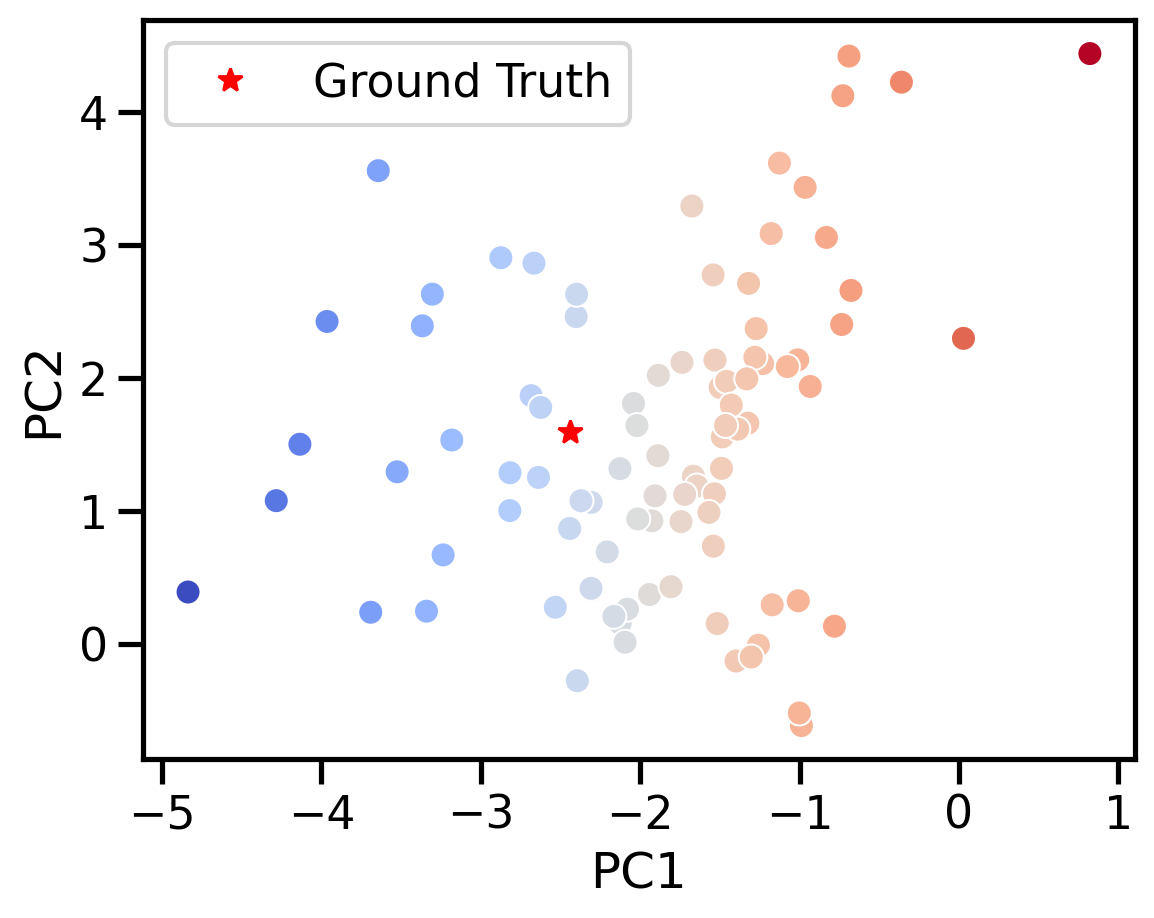

In [26]:
wave(2,SC,PC,ObsReduced)

**_Go back to the HM-Tuning notebook_**

### Wave 3 (for ATM-EVO_MEAN100L experiment)


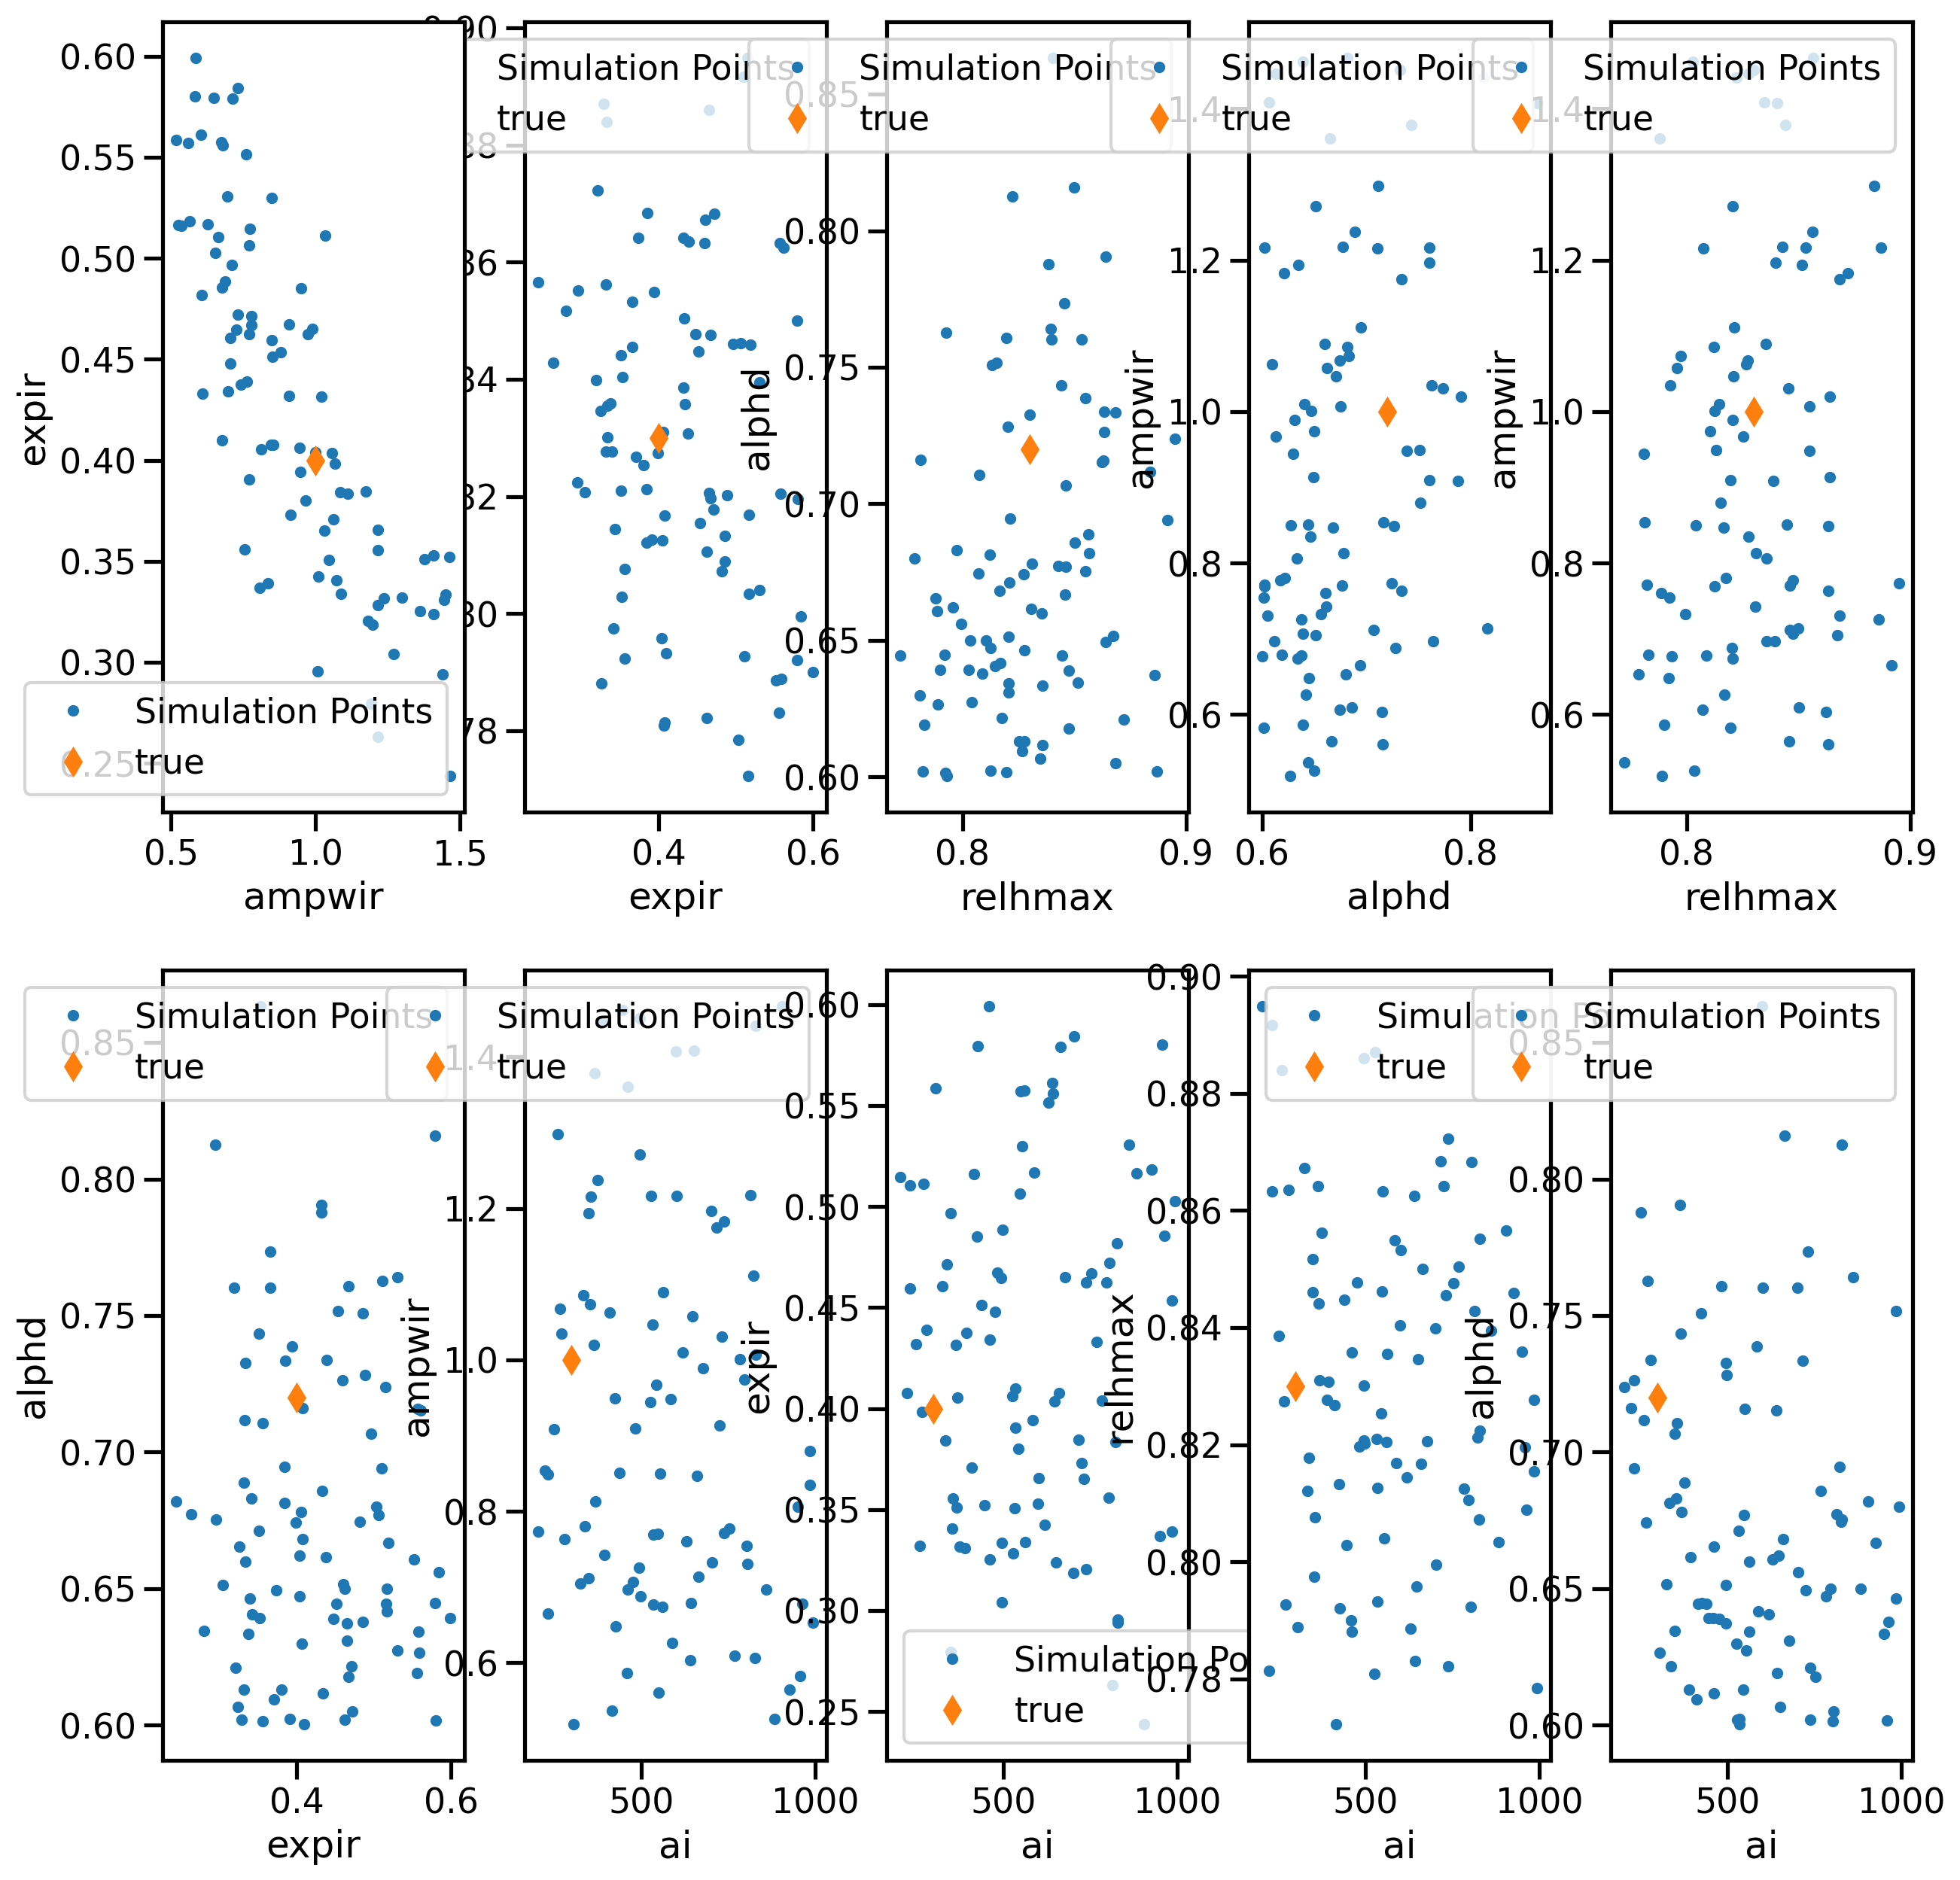

In [27]:
#### load new inputs 
inputs_new = load_inputs_wave(3)
plot_simulation_points(inputs_new.values)

# add values to HM_values.dat
inputs_old = update_HM_values(inputs_old, inputs_new)

# launch simulations 

**_Launch iLOVECLIM simulations. Wait for the simulations to finish_** 

WAVE 3
90
PCA WAVE 3


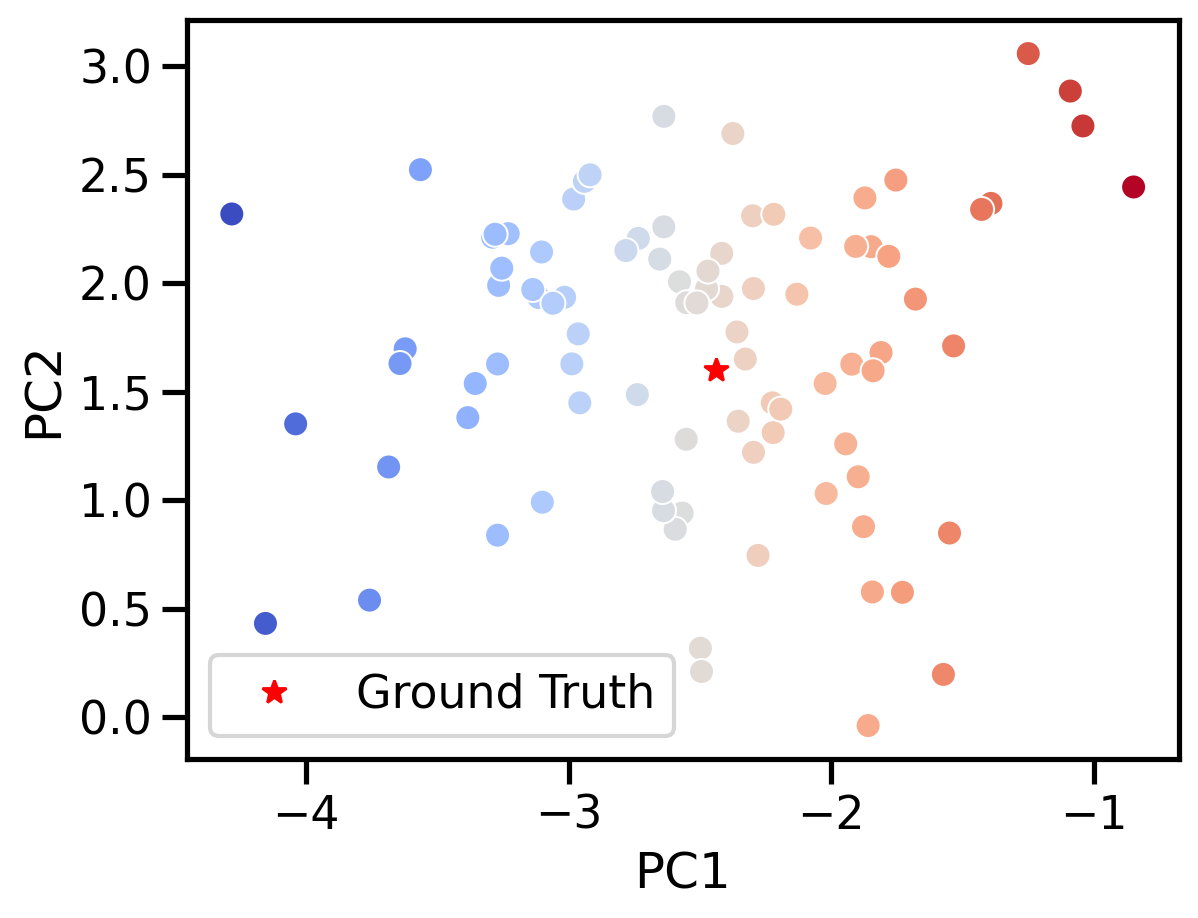

In [28]:
wave(3,SC,PC,ObsReduced)

And so on...